EDA Data Loaded Successfully.


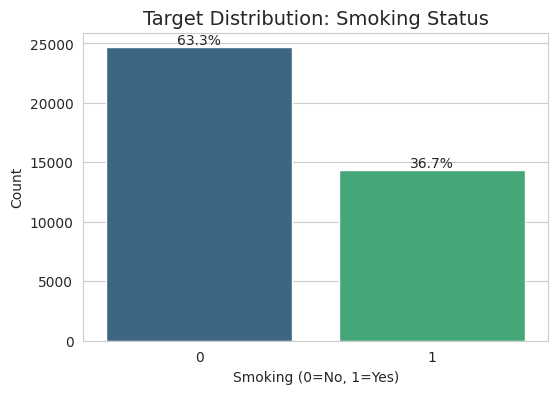

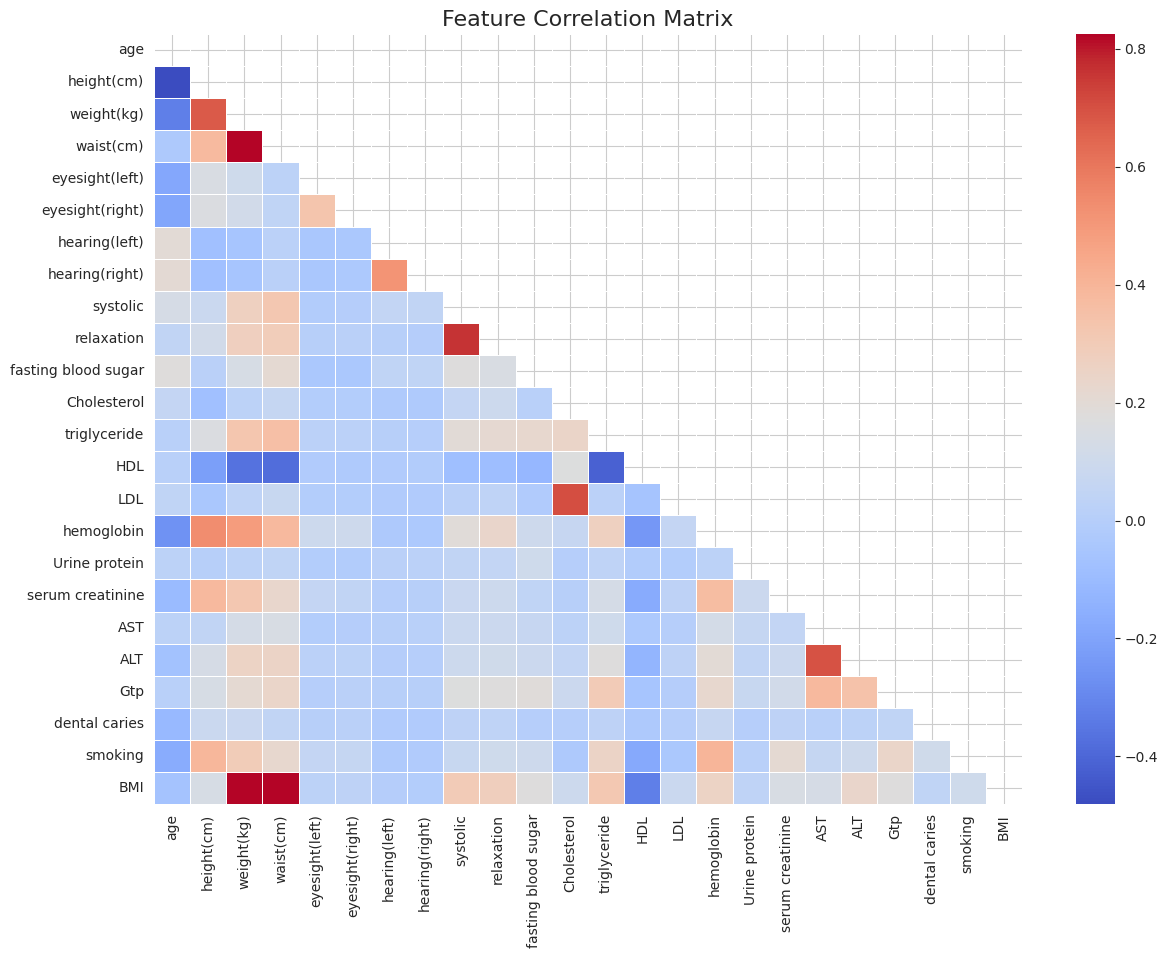

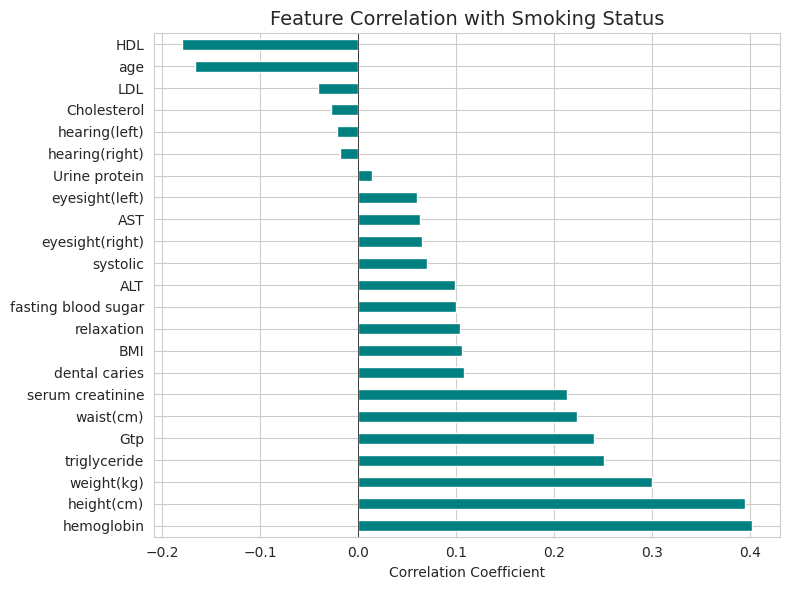

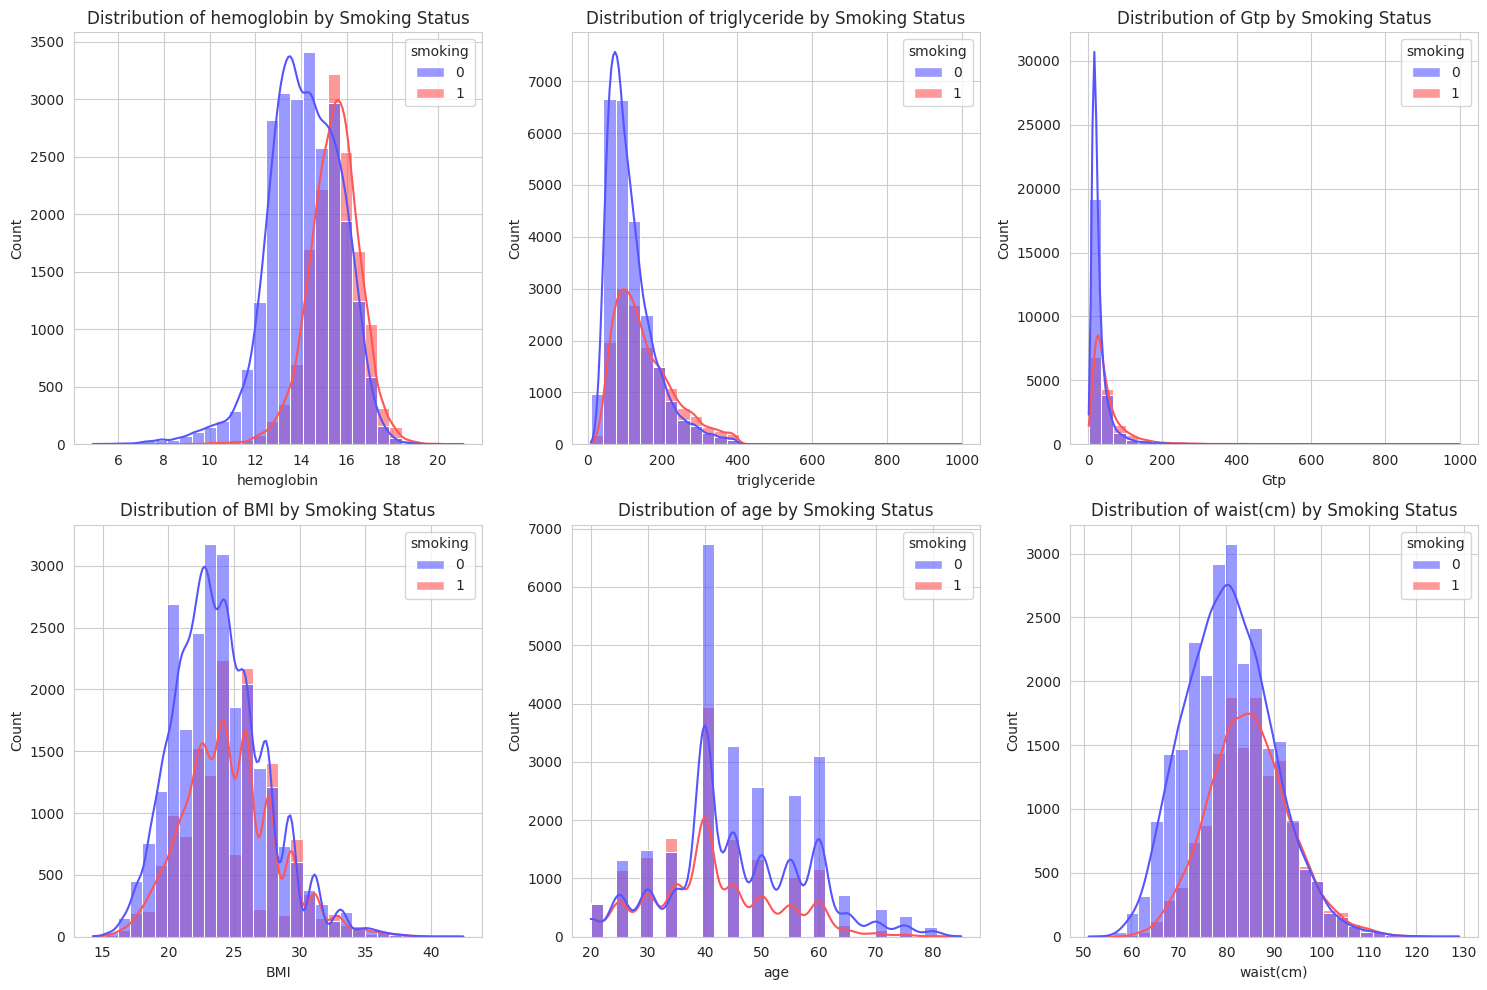

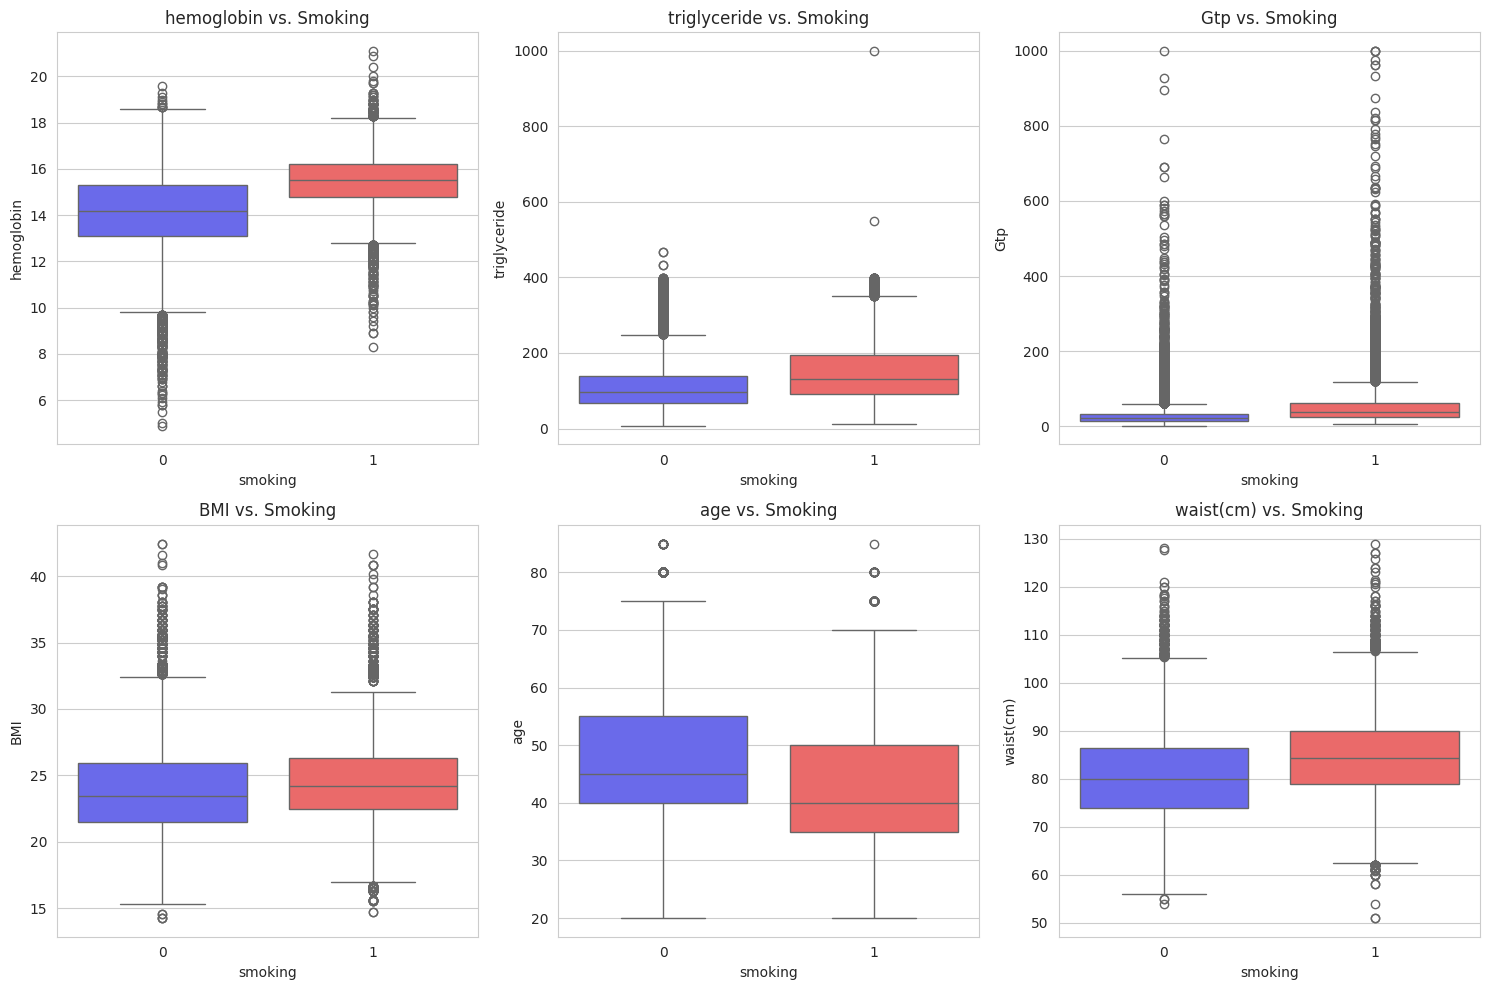

Generating pairplot for top correlated features: ['hemoglobin', 'height(cm)', 'weight(kg)']


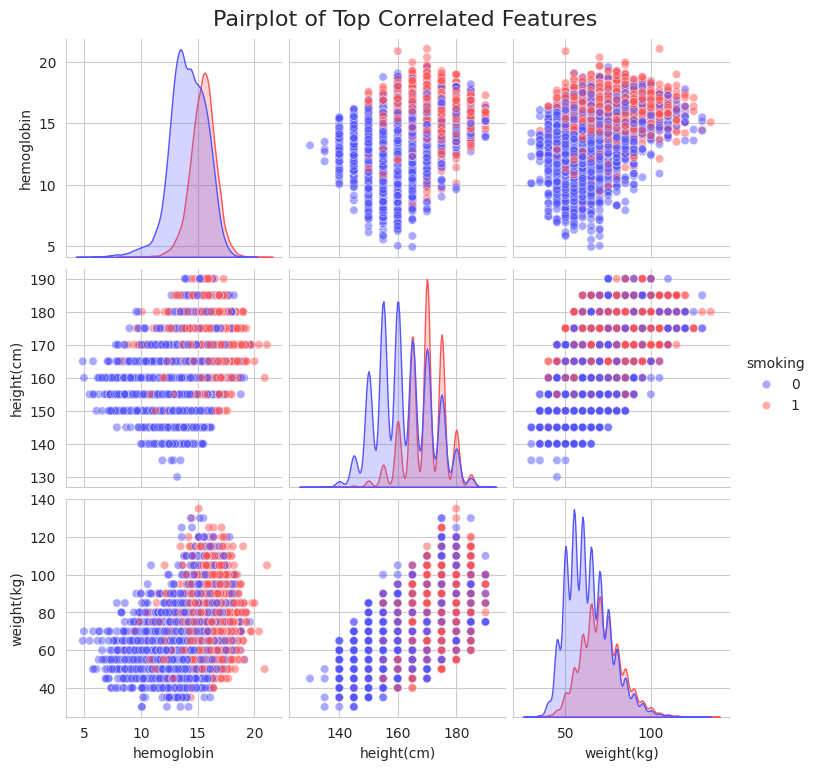

EDA Complete. Key insights:
1. Check class balance in the first chart.
2. 'Hemoglobin', 'Triglyceride', and 'GTP' often show distinct shifts for smokers.
3. Notice the skewness in 'Gtp' and 'Triglyceride' in histograms -> supports using Log Transform.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Load Data
if os.path.exists('smoker_dataset.csv'):
    df_eda = pd.read_csv('smoker_dataset.csv')
    print("EDA Data Loaded Successfully.")
else:
    # Fallback for demonstration if file is missing
    print("Warning: 'smoker_dataset.csv' not found. Generating dummy data for EDA demonstration...")
    np.random.seed(42)
    df_eda = pd.DataFrame({
        'age': np.random.randint(20, 80, 1000),
        'height(cm)': np.random.normal(170, 10, 1000),
        'weight(kg)': np.random.normal(70, 15, 1000),
        'waist(cm)': np.random.normal(85, 10, 1000),
        'systolic': np.random.normal(120, 15, 1000),
        'relaxation': np.random.normal(80, 10, 1000),
        'triglyceride': np.random.exponential(150, 1000), # Often skewed
        'hemoglobin': np.random.normal(15, 2, 1000),
        'Gtp': np.random.exponential(30, 1000),
        'smoking': np.random.randint(0, 2, 1000)
    })

# Feature Engineering for EDA 
df_eda['BMI'] = df_eda['weight(kg)'] / ((df_eda['height(cm)'] / 100) ** 2)

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 2. Target Variable Distribution ---
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='smoking', data=df_eda, palette='viridis', hue='smoking', legend=False)
plt.title('Target Distribution: Smoking Status', fontsize=14)
plt.xlabel('Smoking (0=No, 1=Yes)')
plt.ylabel('Count')
# Add percentage labels
total = len(df_eda)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.show()

# --- 3. Correlation Heatmap ---
# Calculate correlation matrix
corr = df_eda.corr()
# Mask upper triangle to reduce visual clutter
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 10))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()

# Focus on correlation with Target
plt.figure(figsize=(8, 6))
corr['smoking'].sort_values(ascending=False).drop('smoking').plot(kind='barh', color='teal')
plt.title('Feature Correlation with Smoking Status', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- 4. Distribution of Key Numerical Features ---

key_features = ['hemoglobin', 'triglyceride', 'Gtp', 'BMI', 'age', 'waist(cm)']
# Filter only existing columns just in case
key_features = [col for col in key_features if col in df_eda.columns]

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_features):
    plt.subplot(2, 3, i + 1)
    # Using Histplot to see the shape
    sns.histplot(data=df_eda, x=col, hue='smoking', kde=True, palette='seismic', bins=30, alpha=0.6)
    plt.title(f'Distribution of {col} by Smoking Status')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# --- 5. Boxplots for Outlier Detection & Separation ---
plt.figure(figsize=(15, 10))
for i, col in enumerate(key_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='smoking', y=col, data=df_eda, palette='seismic', hue='smoking', legend=False)
    plt.title(f'{col} vs. Smoking')
plt.tight_layout()
plt.show()

# --- 6. Pairplot for Top Correlated Features ---
# Visualizing interactions between the top 3 correlated features
if len(corr) > 3:
    top_corr_features = corr['smoking'].abs().sort_values(ascending=False).index[1:4].tolist()
    print(f"Generating pairplot for top correlated features: {top_corr_features}")

    sns.pairplot(df_eda[top_corr_features + ['smoking']], hue='smoking', palette='seismic', plot_kws={'alpha': 0.5})
    plt.suptitle('Pairplot of Top Correlated Features', y=1.02, fontsize=16)
    plt.show()

print("EDA Complete. Key insights:")
print("1. Check class balance in the first chart.")
print("2. 'Hemoglobin', 'Triglyceride', and 'GTP' often show distinct shifts for smokers.")
print("3. Notice the skewness in 'Gtp' and 'Triglyceride' in histograms -> supports using Log Transform.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load Data

try:
    df = pd.read_csv('smoker_dataset.csv')
except FileNotFoundError:
    print("Error: Dataset not found. Please ensure 'smoker_dataset.csv' is in the working directory.")
    # Create dummy data for code verification if file is missing
    df = pd.DataFrame(np.random.rand(100, 10), columns=[f'col_{i}' for i in range(9)] + ['smoking'])
    df['smoking'] = np.random.randint(0, 2, 100)

# --- Feature Engineering ---
# Check if columns exist before creating derived features
if 'weight(kg)' in df.columns and 'height(cm)' in df.columns:
    df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)

if 'systolic' in df.columns and 'relaxation' in df.columns:
    df['Pulse_Pressure'] = df['systolic'] - df['relaxation']

# 3. Log-transform skewed enzymes
skewed_cols = ['Gtp', 'ALT', 'AST', 'triglyceride']
for col in skewed_cols:
    if col in df.columns:
        df[f'Log_{col}'] = np.log1p(df[col])

# Drop original skewed columns
df_clean = df.drop([c for c in skewed_cols if c in df.columns], axis=1)

# Split X and y
X = df_clean.drop('smoking', axis=1)
y = df_clean['smoking']

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize results dictionary
if 'results' not in locals():
    results = {}

print("Data loaded and preprocessed.")
print(f"Training shape: {X_train_scaled.shape}")

Data loaded and preprocessed.
Training shape: (31187, 24)


In [5]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score

print("\n--- Training Logistic Regression (Polynomial) ---")

pipe_lr = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), # Adds non-linear interactions
    ('select', SelectKBest(f_classif, k=300)), # Keep top 300 interactions
    ('clf', LogisticRegression(class_weight='balanced', max_iter=2000, C=0.1, solver='saga'))
])

start = time.time()
pipe_lr.fit(X_train_scaled, y_train)
lr_time = time.time() - start

y_pred_lr = pipe_lr.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression (Poly) Accuracy: {acc_lr:.4f}")

# Store results
results['Logistic Regression (Poly)'] = {
    'Accuracy': acc_lr,
    'F1-Macro': f1_score(y_test, y_pred_lr, average='macro'),
    'Time': lr_time
}


--- Training Logistic Regression (Polynomial) ---
Logistic Regression (Poly) Accuracy: 0.7232


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [6]:
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

print("\n--- Training SVM (RBF Kernel) ---")

# C=10 allows SVM to fit tighter boundaries
svm_model = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=False, random_state=42)

start = time.time()
svm_model.fit(X_train_scaled, y_train)
svm_time = time.time() - start

y_pred_svm = svm_model.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {acc_svm:.4f}")

# Store results
results['SVM (RBF)'] = {
    'Accuracy': acc_svm,
    'F1-Macro': f1_score(y_test, y_pred_svm, average='macro'),
    'Time': svm_time
}


--- Training SVM (RBF Kernel) ---
SVM Accuracy: 0.7326


In [ ]:
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks
from sklearn.metrics import accuracy_score, f1_score

print("\n--- Training Neural Network (Deep) ---")

def build_deep_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4), # Higher dropout to force generalization

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

nn_model = build_deep_model(X_train_scaled.shape[1])

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5)

start = time.time()
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_schedule],
    verbose=0 
)
nn_time = time.time() - start

y_pred_prob = nn_model.predict(X_test_scaled, verbose=0)
y_pred_nn = (y_pred_prob > 0.5).astype(int).flatten()
acc_nn = accuracy_score(y_test, y_pred_nn)

print(f"Neural Network Accuracy: {acc_nn:.4f}")

# Store results
results['Neural Network'] = {
    'Accuracy': acc_nn,
    'F1-Macro': f1_score(y_test, y_pred_nn, average='macro'),
    'Time': nn_time
}


--- Training Neural Network (Deep) ---
Neural Network Accuracy: 0.7525



===Model Leaderboard ===
                            Accuracy  F1-Macro        Time
Neural Network              0.752469  0.736649   57.915204
SVM (RBF)                   0.732589  0.728244  133.615707
Logistic Regression (Poly)  0.723227  0.720016  378.790786


/tmp/ipython-input-812745112.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')


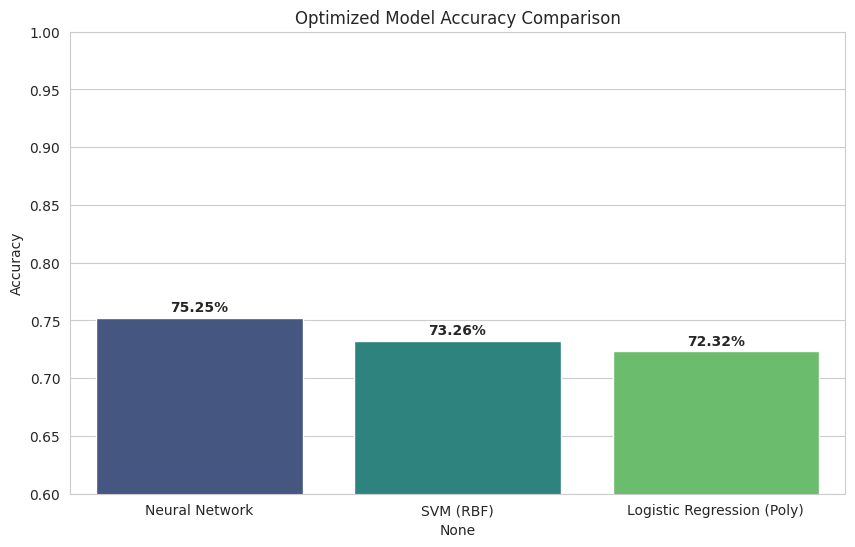

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 5. FINAL COMPARISON
# ---------------------------------------------------------

if not results:
    print("No models trained yet. Please run blocks 2, 3, or 4.")
else:
    results_df = pd.DataFrame(results).T.sort_values(by='Accuracy', ascending=False)
    print("\n===Model Leaderboard ===")
    print(results_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')
    plt.title('Optimized Model Accuracy Comparison')
    plt.ylim(0.6, 1.0) # Adjusted based on expected range
    for i, v in enumerate(results_df['Accuracy']):
        plt.text(i, v + 0.005, f"{v:.2%}", ha='center', fontweight='bold')
    plt.show()

In [10]:
from sklearn.metrics import classification_report

print("\n--- Classification Report for Logistic Regression (Polynomial) ---")
print(classification_report(y_test, y_pred_lr))

print("\n--- Classification Report for SVM (RBF) ---")
print(classification_report(y_test, y_pred_svm))

print("\n--- Classification Report for Neural Network ---")
print(classification_report(y_test, y_pred_nn))


--- Classification Report for Logistic Regression (Polynomial) ---
              precision    recall  f1-score   support

           0       0.88      0.66      0.75      4933
           1       0.59      0.84      0.69      2864

    accuracy                           0.72      7797
   macro avg       0.73      0.75      0.72      7797
weighted avg       0.77      0.72      0.73      7797


--- Classification Report for SVM (RBF) ---
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      4933
           1       0.60      0.83      0.69      2864

    accuracy                           0.73      7797
   macro avg       0.73      0.75      0.73      7797
weighted avg       0.77      0.73      0.74      7797


--- Classification Report for Neural Network ---
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4933
           1       0.65      0.69      0.67      2864

    accuracy       